       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

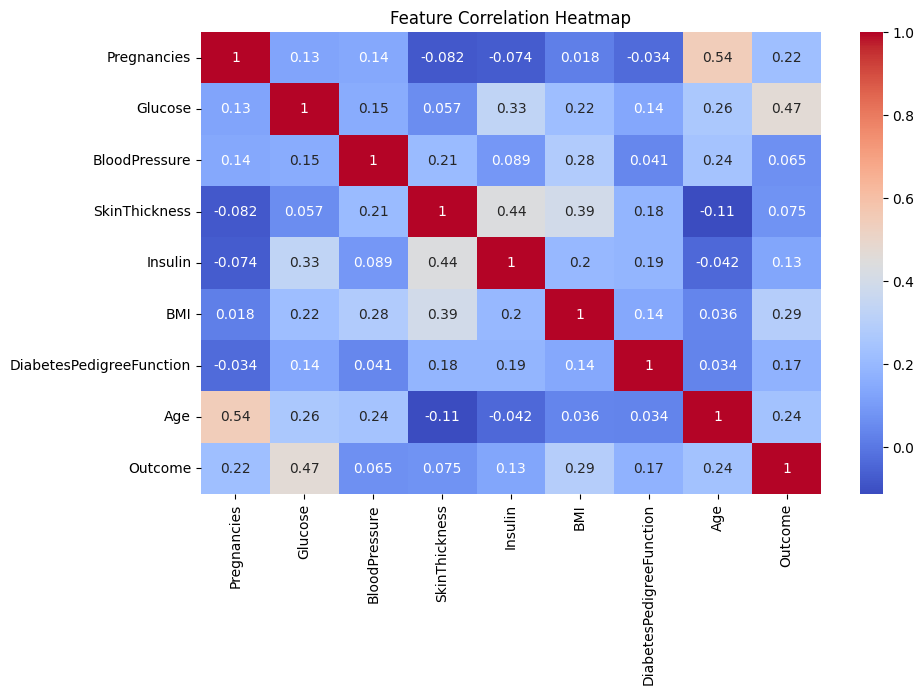

Accuracy: 0.7207792207792207
ROC-AUC: 0.706060606060606
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        99
           1       0.60      0.65      0.63        55

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154



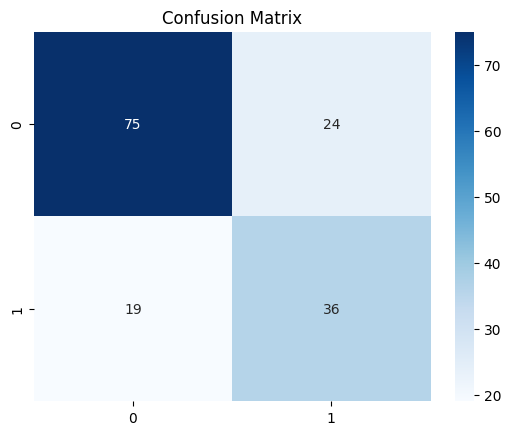

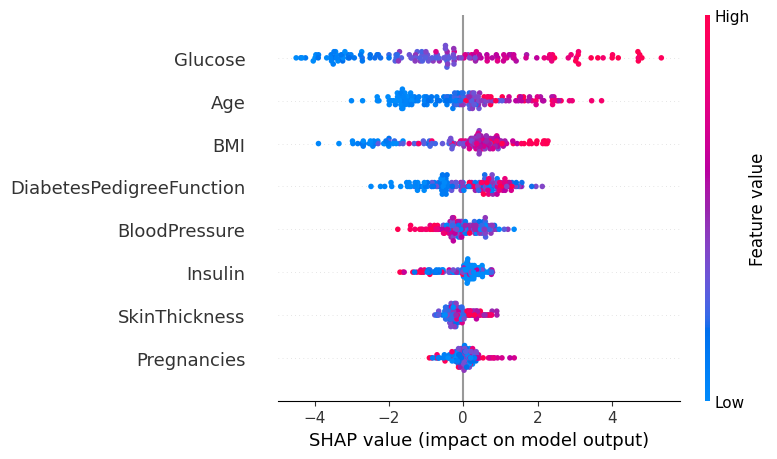

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import shap
import joblib
import os

# 2. Load Dataset
data = pd.read_csv("/content/diabetes.csv")  # Ensure this CSV is in data/
data.head()

# 3. EDA
print(data.describe())
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# 4. Preprocessing
cols_with_zeros = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for col in cols_with_zeros:
    data[col] = data[col].replace(0, data[col].median())

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4a. Create models folder to save model & scaler
if not os.path.exists("../models"):
    os.makedirs("../models")

joblib.dump(scaler, "../models/scaler.pkl")

# 5. Train Model
model = XGBClassifier(random_state=42)
model.fit(X_train_scaled, y_train)
joblib.dump(model, "../src/diabetes_model.pkl")

# 6. Evaluate Model
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 7. Explainable AI using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Global feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Individual explanation example (first test sample)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])
